In [114]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline


In [115]:

class SymbolGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.available_symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'x', 'y', 't', ',']
        print("Доступные символы:", self.available_symbols)
        
    def get_symbol_folder_name(self, char):
        """Преобразует символ в имя папки"""
        if char == 'x':
            return 'X'
        else:
            return char
    
    def get_random_symbol_image(self, char):
        """Получает случайное изображение символа"""
        folder_name = self.get_symbol_folder_name(char)
        symbol_dir = os.path.join(self.data_path, folder_name)
        
        if not os.path.exists(symbol_dir):
            print(f"Предупреждение: папка {symbol_dir} не существует")
            return self.create_dummy_symbol(char)
        
        images = [f for f in os.listdir(symbol_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        if not images:
            print(f"Предупреждение: нет изображений в {symbol_dir}")
            return self.create_dummy_symbol(char)
        
        random_image = random.choice(images)
        img_path = os.path.join(symbol_dir, random_image)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Ошибка загрузки: {img_path}")
            return self.create_dummy_symbol(char)
            
        return img
    
    def create_dummy_symbol(self, char):
        """Создает тестовое изображение символа"""
        img = np.ones((45, 45), dtype=np.uint8) * 255
        cv2.putText(img, char, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 0, 2)
        return img
    
    def generate_sequence(self, length=8):
        """Генерирует случайную последовательность символов"""
        sequence = ''.join(random.choices(self.available_symbols, k=length))
        print(f"Генерируем: '{sequence}'")
        images = []
        
        for char in sequence:
            img = self.get_random_symbol_image(char)
            images.append(img)
        
        return sequence, images

def create_sequence_image(images, spacing=20):
    """Склеивает изображения символов в одну последовательность"""
    if not images:
        return np.ones((100, 100), dtype=np.uint8) * 255
    
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h) // 2
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return sequence_img

In [116]:
def create_sequence_image(images, spacing=20):
    """Склеивает изображения символов в одну последовательность"""
    if not images:
        return np.ones((100, 100), dtype=np.uint8) * 255
    
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h) // 2
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return sequence_img

Доступные символы: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'x', 'y', 't', ',']
Генерируем: '39+x5913'


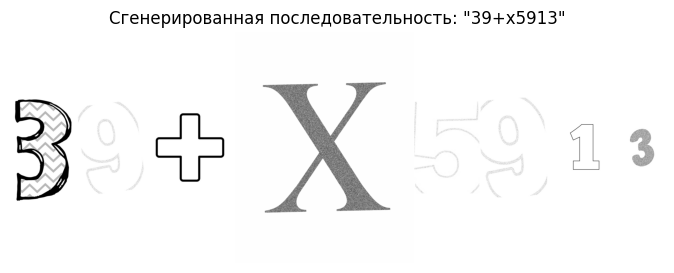

✓ Последовательность сгенерирована


In [120]:

your_data_path = r'C:\Users\engfile\image_processing\dz8\image'
generator = SymbolGenerator(your_data_path)


sequence, images = generator.generate_sequence(length=8)
sequence_image = create_sequence_image(images, spacing=15)


plt.figure(figsize=(12, 3))
plt.imshow(sequence_image, cmap='gray')
plt.title(f'Сгенерированная последовательность: "{sequence}"')
plt.axis('off')
plt.show()

print("✓ Последовательность сгенерирована")

Загружаем реальные символы из папки для тестирования...
Загружен символ '1' из папки 1
Загружен символ '2' из папки 2
Загружен символ '+' из папки +
Загружен символ '3' из папки 3
Загружен символ 'x' из папки X
Загружен символ '4' из папки 4
Загружен символ 'y' из папки y
Загружен символ '5' из папки 5
Загружено 8 реальных символов: '12+3x4y5'


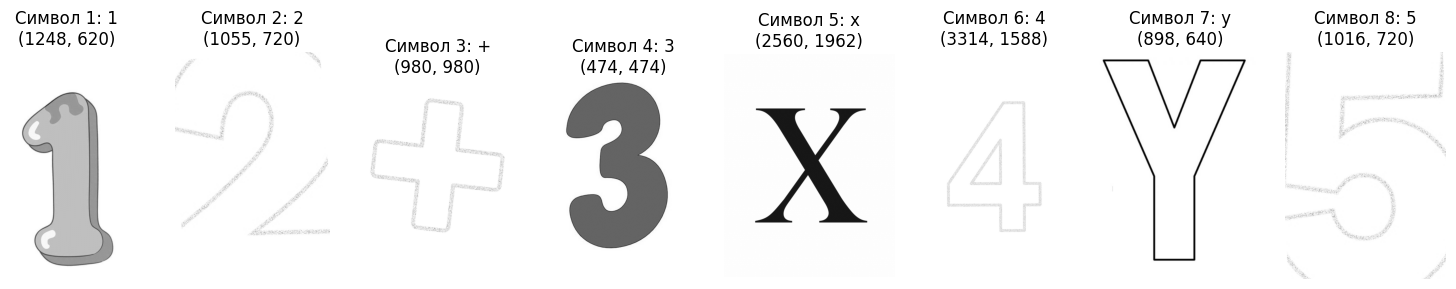

✓ Создана тестовая последовательность из реальных символов: '12+3x4y5'


In [121]:
def get_real_symbols_from_folder(data_path):
    """Берет реальные символы из папки для тестирования"""
    test_symbols = []
    test_sequence = ""
    symbols_to_test = ['1', '2', '+', '3', 'x', '4', 'y', '5']
    
    for symbol in symbols_to_test:
        folder_name = symbol
        if symbol == 'x':
            folder_name = 'X'
        
        folder_path = os.path.join(data_path, folder_name)
        
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:
                img_path = os.path.join(folder_path, images[0])
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    test_symbols.append((len(test_symbols) * 100, img))
                    test_sequence += symbol
                    print(f"Загружен символ '{symbol}' из папки {folder_name}")
                else:
                    print(f"Не удалось загрузить изображение для '{symbol}'")
            else:
                print(f"Нет изображений в папке {folder_name}")
        else:
            print(f"Папка {folder_name} не существует")
    
    return test_symbols, test_sequence

print("Загружаем реальные символы из папки для тестирования...")
symbols_data, test_sequence = get_real_symbols_from_folder(your_data_path)

if symbols_data:

    print(f"Загружено {len(symbols_data)} реальных символов: '{test_sequence}'")
    
    plt.figure(figsize=(15, 3))
    for i, (x, symbol_img) in enumerate(symbols_data):
        plt.subplot(1, len(symbols_data), i+1)
        plt.imshow(symbol_img, cmap='gray')
        plt.title(f'Символ {i+1}: {test_sequence[i]}\n{symbol_img.shape}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    sequence = test_sequence
    print(f"✓ Создана тестовая последовательность из реальных символов: '{sequence}'")
else:
    print("Не удалось загрузить символы из папки!")

    print("Создаем искусственные символы...")
    
    def create_backup_symbols():
        test_symbols = []
        symbols = ['1', '2', '+', '3', '4', '5', '6', '7']
        
        for i, symbol in enumerate(symbols):
            img = np.ones((100, 80), dtype=np.uint8) * 255
            cv2.putText(img, symbol, (25, 65), cv2.FONT_HERSHEY_SIMPLEX, 1.3, 0, 3)
            test_symbols.append((i * 100, img))
        
        return test_symbols, ''.join(symbols)
    
    symbols_data, sequence = create_backup_symbols()
    
    plt.figure(figsize=(15, 3))
    for i, (x, symbol_img) in enumerate(symbols_data):
        plt.subplot(1, len(symbols_data), i+1)
        plt.imshow(symbol_img, cmap='gray')
        plt.title(f'Символ {i+1}: {sequence[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Нормализуем символы:
  Символ 1 ('1'): (1248, 620) -> (45, 45)
  Символ 2 ('2'): (1055, 720) -> (45, 45)
  Символ 3 ('+'): (980, 980) -> (45, 45)
  Символ 4 ('3'): (474, 474) -> (45, 45)
  Символ 5 ('x'): (2560, 1962) -> (45, 45)
  Символ 6 ('4'): (3314, 1588) -> (45, 45)
  Символ 7 ('y'): (898, 640) -> (45, 45)
  Символ 8 ('5'): (1016, 720) -> (45, 45)
✓ Символы нормализованы


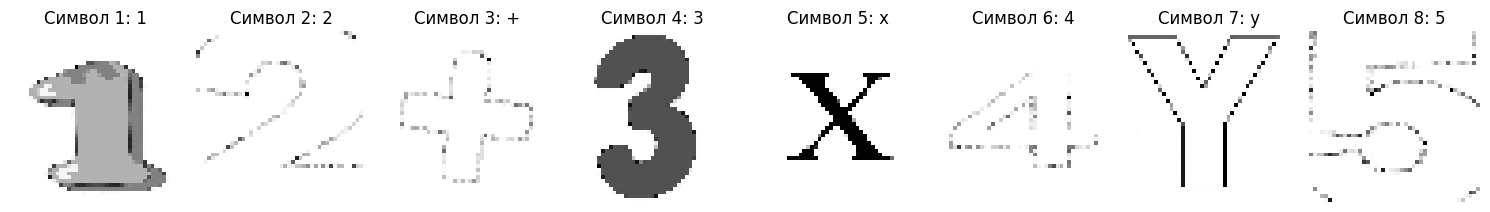

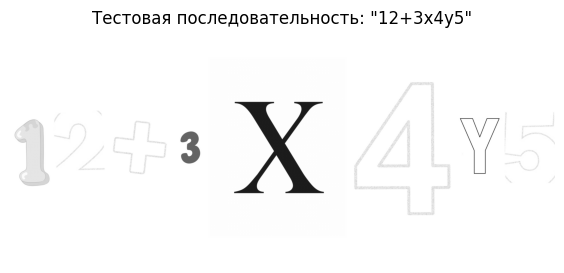

✓ Создано общее изображение последовательности


In [123]:
def normalize_symbol_size(symbol_img, target_size=45):
    """Приводит символ к стандартному размеру"""
    h, w = symbol_img.shape

    resized = cv2.resize(symbol_img, (target_size, target_size))
    return resized

def create_combined_sequence(symbols_data, spacing=20):
    """Создает одно изображение из всех символов"""
    images = [img for _, img in symbols_data]
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    combined_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h) // 2
        combined_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return combined_img

normalized_symbols = []
print("Нормализуем символы:")

for i, (x, symbol_img) in enumerate(symbols_data):
    print(f"  Символ {i+1} ('{sequence[i]}'): {symbol_img.shape} -> ", end="")
    normalized = normalize_symbol_size(symbol_img)
    normalized_symbols.append((x, normalized))
    print(f"{normalized.shape}")

print("✓ Символы нормализованы")

plt.figure(figsize=(15, 3))
for i, (x, symbol_img) in enumerate(normalized_symbols):
    plt.subplot(1, len(normalized_symbols), i+1)
    plt.imshow(symbol_img, cmap='gray')
    plt.title(f'Символ {i+1}: {sequence[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

symbols_sorted = sorted(normalized_symbols, key=lambda x: x[0])

sequence_image = create_combined_sequence(symbols_data, spacing=15)

plt.figure(figsize=(12, 3))
plt.imshow(sequence_image, cmap='gray')
plt.title(f'Тестовая последовательность: "{sequence}"')
plt.axis('off')
plt.show()

print("✓ Создано общее изображение последовательности")

In [124]:
def augment_existing_images(data_path):
    """Создает дополнительные варианты изображений через аугментацию"""
    print("Создаем дополнительные варианты изображений...")
    
    symbols_folders = {
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', 
        '6': '6', '7': '7', '8': '8', '9': '9',
        '+': '+', '-': '-', 
        'X': 'x', 't': 't', 'y': 'y', ',': ','
    }
    
    for folder_name, symbol in symbols_folders.items():
        folder_path = os.path.join(data_path, folder_name)
        
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:
                original_path = os.path.join(folder_path, images[0])
                original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
                
                if original_img is not None:

                    for i in range(1, 10):
                        augmented = original_img.copy()
                        angle = np.random.uniform(-5, 5)
                        scale = np.random.uniform(0.9, 1.1)
                        
                        h, w = augmented.shape
                        center = (w // 2, h // 2)

                        M = cv2.getRotationMatrix2D(center, angle, scale)
                        augmented = cv2.warpAffine(augmented, M, (w, h), borderValue=255)
                        noise = np.random.normal(0, 5, augmented.shape).astype(np.uint8)
                        augmented = cv2.add(augmented, noise)

                        new_filename = f"{symbol}_{i:02d}.png"
                        new_path = os.path.join(folder_path, new_filename)
                        cv2.imwrite(new_path, augmented)
                    
                    print(f"✓ Создано 9 вариантов для '{symbol}'")

def load_training_data_with_augmentation(data_path):
    """Загрузка обучающих данных с аугментацией"""

    augment_existing_images(data_path)
    
    X = []
    y = []
    
    symbols_folders = {
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', 
        '6': '6', '7': '7', '8': '8', '9': '9',
        '+': '+', '-': '-', 
        'X': 'x', 't': 't', 'y': 'y', ',': ','
    }
    
    for folder_name, symbol in symbols_folders.items():
        folder_path = os.path.join(data_path, folder_name)
        
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:
                print(f"Загружаем {len(images)} изображений для '{symbol}'")
                
                for img_name in images:
                    img_path = os.path.join(folder_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        normalized = normalize_symbol_size(img)
                        X.append(normalized.flatten())
                        y.append(symbol)
    
    print(f"\nВсего загружено: {len(X)} изображений")
    print(f"Классы: {set(y)}")
    return np.array(X), np.array(y)

X_train, y_train = load_training_data_with_augmentation(your_data_path)

if len(X_train) > 0:
    print(f"✓ Успешно загружено {len(X_train)} изображений")
    print(f"✓ Размерность данных: {X_train.shape}")
else:
    print("❌ Не удалось загрузить данные!")

Создаем дополнительные варианты изображений...
✓ Создано 9 вариантов для '0'
✓ Создано 9 вариантов для '1'
✓ Создано 9 вариантов для '2'
✓ Создано 9 вариантов для '3'
✓ Создано 9 вариантов для '4'
✓ Создано 9 вариантов для '5'
✓ Создано 9 вариантов для '6'
✓ Создано 9 вариантов для '7'
✓ Создано 9 вариантов для '8'
✓ Создано 9 вариантов для '9'
✓ Создано 9 вариантов для '+'
✓ Создано 9 вариантов для '-'
✓ Создано 9 вариантов для 'x'
✓ Создано 9 вариантов для 't'
✓ Создано 9 вариантов для 'y'
✓ Создано 9 вариантов для ','
Загружаем 13 изображений для '0'
Загружаем 12 изображений для '1'
Загружаем 11 изображений для '2'
Загружаем 13 изображений для '3'
Загружаем 10 изображений для '4'
Загружаем 10 изображений для '5'
Загружаем 10 изображений для '6'
Загружаем 10 изображений для '7'
Загружаем 10 изображений для '8'
Загружаем 10 изображений для '9'
Загружаем 12 изображений для '+'
Загружаем 12 изображений для '-'
Загружаем 10 изображений для 'x'
Загружаем 10 изображений для 't'
Загружаем 1

In [125]:
def augment_existing_images(data_path):
    """Создает дополнительные варианты изображений через аугментацию"""
    print("Создаем дополнительные варианты изображений...")
    
    symbols_folders = {
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', 
        '6': '6', '7': '7', '8': '8', '9': '9',
        '+': '+', '-': '-', 
        'X': 'x', 't': 't', 'y': 'y', ',': ','
    }
    
    for folder_name, symbol in symbols_folders.items():
        folder_path = os.path.join(data_path, folder_name)
        
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:
                original_path = os.path.join(folder_path, images[0])
                original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
                
                if original_img is not None:

                    for i in range(1, 10):
                        augmented = original_img.copy()

                        angle = np.random.uniform(-5, 5)
                        scale = np.random.uniform(0.9, 1.1)
                        
                        h, w = augmented.shape
                        center = (w // 2, h // 2)

                        M = cv2.getRotationMatrix2D(center, angle, scale)
                        augmented = cv2.warpAffine(augmented, M, (w, h), borderValue=255)

                        noise = np.random.normal(0, 5, augmented.shape).astype(np.uint8)
                        augmented = cv2.add(augmented, noise)

                        new_filename = f"{symbol}_{i:02d}.png"
                        new_path = os.path.join(folder_path, new_filename)
                        cv2.imwrite(new_path, augmented)
                    
                    print(f"✓ Создано 9 вариантов для '{symbol}'")

def load_training_data_with_augmentation(data_path):

    augment_existing_images(data_path)
    
    X = []
    y = []
    
    symbols_folders = {
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', 
        '6': '6', '7': '7', '8': '8', '9': '9',
        '+': '+', '-': '-', 
        'X': 'x', 't': 't', 'y': 'y', ',': ','
    }
    
    for folder_name, symbol in symbols_folders.items():
        folder_path = os.path.join(data_path, folder_name)
        
        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:
                print(f"Загружаем {len(images)} изображений для '{symbol}'")
                
                for img_name in images:
                    img_path = os.path.join(folder_path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        normalized = normalize_symbol_size(img)
                        X.append(normalized.flatten())
                        y.append(symbol)
    
    print(f"\nВсего загружено: {len(X)} изображений")
    print(f"Классы: {set(y)}")
    return np.array(X), np.array(y)

X_train, y_train = load_training_data_with_augmentation(your_data_path)

if len(X_train) > 0:
    print(f"Успешно загружено {len(X_train)} изображений")
    print(f"Размерность данных: {X_train.shape}")
else:
    print("Не удалось загрузить данные!")

Создаем дополнительные варианты изображений...
✓ Создано 9 вариантов для '0'
✓ Создано 9 вариантов для '1'
✓ Создано 9 вариантов для '2'
✓ Создано 9 вариантов для '3'
✓ Создано 9 вариантов для '4'
✓ Создано 9 вариантов для '5'
✓ Создано 9 вариантов для '6'
✓ Создано 9 вариантов для '7'
✓ Создано 9 вариантов для '8'
✓ Создано 9 вариантов для '9'
✓ Создано 9 вариантов для '+'
✓ Создано 9 вариантов для '-'
✓ Создано 9 вариантов для 'x'
✓ Создано 9 вариантов для 't'
✓ Создано 9 вариантов для 'y'
✓ Создано 9 вариантов для ','
Загружаем 13 изображений для '0'
Загружаем 12 изображений для '1'
Загружаем 11 изображений для '2'
Загружаем 13 изображений для '3'
Загружаем 10 изображений для '4'
Загружаем 10 изображений для '5'
Загружаем 10 изображений для '6'
Загружаем 10 изображений для '7'
Загружаем 10 изображений для '8'
Загружаем 10 изображений для '9'
Загружаем 12 изображений для '+'
Загружаем 12 изображений для '-'
Загружаем 10 изображений для 'x'
Загружаем 10 изображений для 't'
Загружаем 1

In [126]:
def train_knn_models(X_train, y_train):
    """Обучает KNN модели с разными k"""
    if len(X_train) == 0:
        print(" Нет данных для обучения!")
        return {}
    
    models = {}
    k_values = [1, 3, 5, 7]
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        models[f'knn_{k}'] = knn
        print(f"✓ KNN (k={k}) обучена")
    
    return models

knn_models = train_knn_models(X_train, y_train)

if knn_models:
    print(f"Обучено {len(knn_models)} моделей")
else:
    print(" Не удалось обучить модели!")

✓ KNN (k=1) обучена
✓ KNN (k=3) обучена
✓ KNN (k=5) обучена
✓ KNN (k=7) обучена
Обучено 4 моделей


In [127]:
def predict_sequence(model, symbols_data, true_sequence):
    """Распознает последовательность символов"""
    predicted_symbols = []
    
    print("Распознавание:")
    for i, (x, symbol_img) in enumerate(symbols_data):

        img_flat = symbol_img.flatten().reshape(1, -1)

        prediction = model.predict(img_flat)[0]
        predicted_symbols.append(prediction)
        print(f"  Символ {i+1}: '{prediction}'")
    
    predicted_sequence = ''.join(predicted_symbols)

    correct = 0
    errors = []
    for i, (true, pred) in enumerate(zip(true_sequence, predicted_sequence)):
        if true == pred:
            correct += 1
        else:
            errors.append((i, true, pred))
    
    accuracy = correct / len(true_sequence)
    
    return predicted_sequence, accuracy, errors

if symbols_sorted and knn_models:
    print("=" * 50)
    print("РАСПОЗНАВАНИЕ ПОСЛЕДОВАТЕЛЬНОСТИ")
    print("=" * 50)
    print(f"Истинная последовательность: '{sequence}'")
    
    results = {}
    
    for model_name, model in knn_models.items():
        print(f"\n--- {model_name.upper()} ---")
        predicted, accuracy, errors = predict_sequence(model, symbols_sorted, sequence)
        
        results[model_name] = {
            'predicted': predicted,
            'accuracy': accuracy,
            'errors': errors
        }
        
        print(f"Результат: '{predicted}'")
        print(f"Точность: {accuracy:.1%} ({int(accuracy * len(sequence))}/{len(sequence)})")
        
        if errors:
            print("Ошибки:")
            for pos, true, pred in errors:
                print(f"  Позиция {pos+1}: '{true}' → '{pred}'")

    print("\n" + "=" * 50)
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print("=" * 50)
    
    best_model = None
    best_accuracy = 0
    
    for model_name, result in results.items():
        accuracy_percent = result['accuracy'] * 100
        print(f"{model_name:<8} | {accuracy_percent:>6.1f}% | '{result['predicted']}'")
        
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model = model_name
    
    print(f"\nЛучшая модель: {best_model} ({best_accuracy:.1%})")
    
else:
    print("Нет данных для распознавания!")

РАСПОЗНАВАНИЕ ПОСЛЕДОВАТЕЛЬНОСТИ
Истинная последовательность: '12+3x4y5'

--- KNN_1 ---
Распознавание:
  Символ 1: '1'
  Символ 2: '2'
  Символ 3: '+'
  Символ 4: '3'
  Символ 5: 'x'
  Символ 6: '4'
  Символ 7: 'y'
  Символ 8: '5'
Результат: '12+3x4y5'
Точность: 100.0% (8/8)

--- KNN_3 ---
Распознавание:
  Символ 1: '1'
  Символ 2: '2'
  Символ 3: '+'
  Символ 4: '3'
  Символ 5: 'x'
  Символ 6: '4'
  Символ 7: '-'
  Символ 8: '5'
Результат: '12+3x4-5'
Точность: 87.5% (7/8)
Ошибки:
  Позиция 7: 'y' → '-'

--- KNN_5 ---
Распознавание:
  Символ 1: '1'
  Символ 2: '2'
  Символ 3: '+'
  Символ 4: '3'
  Символ 5: 'x'
  Символ 6: '4'
  Символ 7: '-'
  Символ 8: '5'
Результат: '12+3x4-5'
Точность: 87.5% (7/8)
Ошибки:
  Позиция 7: 'y' → '-'

--- KNN_7 ---
Распознавание:
  Символ 1: '1'
  Символ 2: '2'
  Символ 3: '+'
  Символ 4: '3'
  Символ 5: 'x'
  Символ 6: '6'
  Символ 7: '+'
  Символ 8: '5'
Результат: '12+3x6+5'
Точность: 75.0% (6/8)
Ошибки:
  Позиция 6: '4' → '6'
  Позиция 7: 'y' → '+'

С

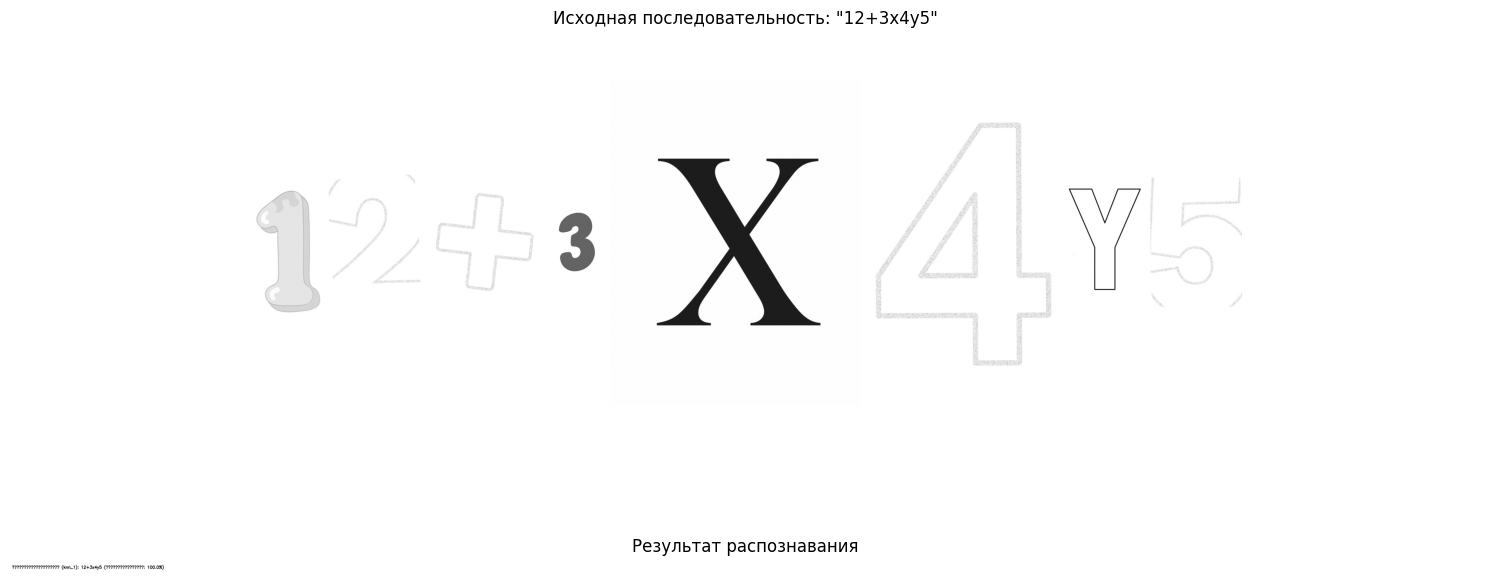

Задание выполнено!


In [128]:
if symbols_sorted and knn_models and results and best_model:
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.imshow(sequence_image, cmap='gray')
    plt.title(f'Исходная последовательность: "{sequence}"')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    result_img = np.ones((100, sequence_image.shape[1]), dtype=np.uint8) * 255

    best_result = results[best_model]
    text = f"Распознано ({best_model}): {best_result['predicted']} (Точность: {best_result['accuracy']:.1%})"
    
    result_img = cv2.cvtColor(result_img, cv2.COLOR_GRAY2BGR)
    cv2.putText(result_img, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    plt.imshow(result_img)
    plt.title('Результат распознавания')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Задание выполнено!")
else:
    print("Не удалось визуализировать результаты!")

Обработка контуров:


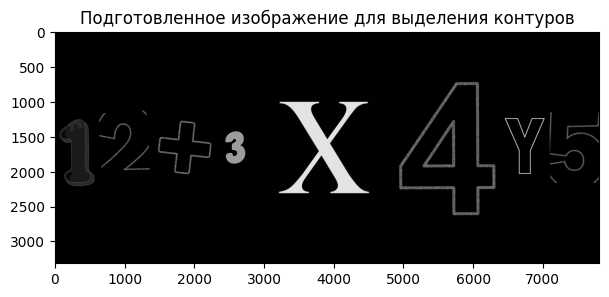

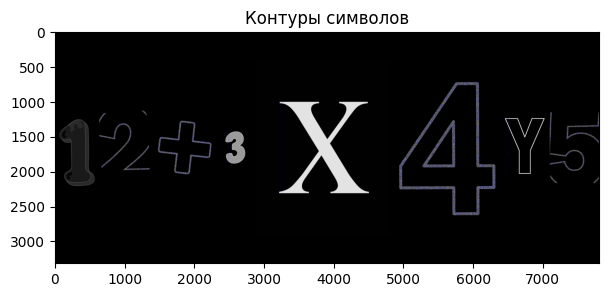

Найдено контуров: 1126


In [129]:
def process_sequence_with_contours(sequence_img):
    """Обработка последовательности с выделением контуров"""
    img_gray = sequence_image.copy()
    kernel = np.ones((3,3),np.uint8)
    img_gray = cv2.erode(img_gray,kernel,iterations = 1)
    img_gray = cv2.bitwise_not(img_gray)
    base_size=img_gray.shape[0],img_gray.shape[1]
    base=np.zeros(base_size,dtype=np.uint8)
    base[0:img_gray.shape[0],0:img_gray.shape[1]]=img_gray
    base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

    img_rgb = base

    plt.figure(figsize=(10, 3))
    plt.imshow(img_rgb)
    plt.title('Подготовленное изображение для выделения контуров')
    plt.show()

    ret,thresh = cv2.threshold(img_rgb,127,255,0)
    thresh = np.uint8(thresh)

    contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
    crops = []

    contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

    for i in range(len(contours_sorted)):
        cnt = contours_sorted[i] 
        area = cv2.contourArea(cnt)
        x,y,w,h = cv2.boundingRect(cnt)
        while (w>45):
            w-=1
        
        if w*h > 50:
            cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,0,255),1)
            crops.append([x,y,w,h]) 

    plt.figure(figsize=(10, 3))
    plt.imshow(img_rgb)
    plt.title('Контуры символов')
    plt.show()
    
    return crops

print("Обработка контуров:")
contours_data = process_sequence_with_contours(sequence_image)
print(f"Найдено контуров: {len(contours_data)}")

In [ ]:
print("=" * 60)
print("ФИНАЛЬНЫЙ ОТЧЕТ")
print("=" * 60)
print(f"Тестовая последовательность: '{sequence}'")
print(f"Количество символов: {len(sequence)}")
print(f"Размер обучающей выборки: {len(X_train)} изображений")
print(f"Количество классов: {len(set(y_train))}")

print("\nРезультаты распознавания:")
for model_name in ['knn_1', 'knn_3', 'knn_5', 'knn_7']:
    if model_name in results:
        acc = results[model_name]['accuracy'] * 100
        pred = results[model_name]['predicted']
        print(f"  {model_name}: {acc:5.1f}% - '{pred}'")

best_acc = results[best_model]['accuracy'] * 100
print(f"\nИтог: Лучшая модель {best_model} показала точность {best_acc:.1f}%")
print("=" * 60)
##test

ФИНАЛЬНЫЙ ОТЧЕТ
Тестовая последовательность: '12+3x4y5'
Количество символов: 8
Размер обучающей выборки: 173 изображений
Количество классов: 16

Результаты распознавания:
  knn_1: 100.0% - '12+3x4y5'
  knn_3:  87.5% - '12+3x4-5'
  knn_5:  87.5% - '12+3x4-5'
  knn_7:  75.0% - '12+3x6+5'

Итог: Лучшая модель knn_1 показала точность 100.0%
